## Importing Libraries

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torchvision
import cv2
import os
from PIL import Image
import keras

from tensorflow.keras import datasets, layers, models

# from torchvision import datasets, transforms, models
from torch.utils.data import Dataset, DataLoader


## Preparing Data

In [ ]:
!unzip  charts.zip
%cd charts

Archive:  charts.zip
   creating: charts/
   creating: charts/test/
  inflating: charts/test/0.png       
  inflating: charts/test/1.png       
  inflating: charts/test/10.png      
  inflating: charts/test/11.png      
 extracting: charts/test/12.png      
 extracting: charts/test/13.png      
  inflating: charts/test/14.png      
  inflating: charts/test/15.png      
  inflating: charts/test/16.png      
  inflating: charts/test/17.png      
  inflating: charts/test/18.png      
  inflating: charts/test/19.png      
  inflating: charts/test/2.png       
  inflating: charts/test/20.png      
  inflating: charts/test/21.png      
  inflating: charts/test/22.png      
  inflating: charts/test/23.png      
  inflating: charts/test/24.png      
  inflating: charts/test/25.png      
  inflating: charts/test/26.png      
  inflating: charts/test/27.png      
  inflating: charts/test/28.png      
  inflating: charts/test/29.png      
  inflating: charts/test/3.png       
  inflating: charts/

In [ ]:
print(f"The total number of images for train_val is {len(os.listdir(os.path.join('train_val')))}")
print(f"The total number of images for train_val is {len(os.listdir(os.path.join('test')))}")


The total number of images for train_val is 1000
The total number of images for train_val is 50


In [ ]:
df = pd.read_csv('/content/charts/train_val.csv')

In [ ]:
df.head()

,image_index,type
0,0,vbar_categorical
1,1,vbar_categorical
2,2,vbar_categorical
3,3,vbar_categorical
4,4,vbar_categorical


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   image_index  1000 non-null   int64 
 1   type         1000 non-null   object
dtypes: int64(1), object(1)
memory usage: 15.8+ KB


In [ ]:
df['type'].value_counts()

vbar_categorical    200
hbar_categorical    200
line                200
pie                 200
dot_line            200
Name: type, dtype: int64

In [ ]:
df['path'] = [f"/content/charts/train_val/{i}.png" for i in df['image_index']]

In [ ]:
df = df.sample(frac = 1).reset_index(drop=True)

In [161]:
df['type'].unique()

array([4, 0, 1, 2, 3])

In [ ]:
df['type'] = df['type'].map({'vbar_categorical': 0 , 'hbar_categorical': 1,'line': 2, 'pie':3, 'dot_line': 4 })

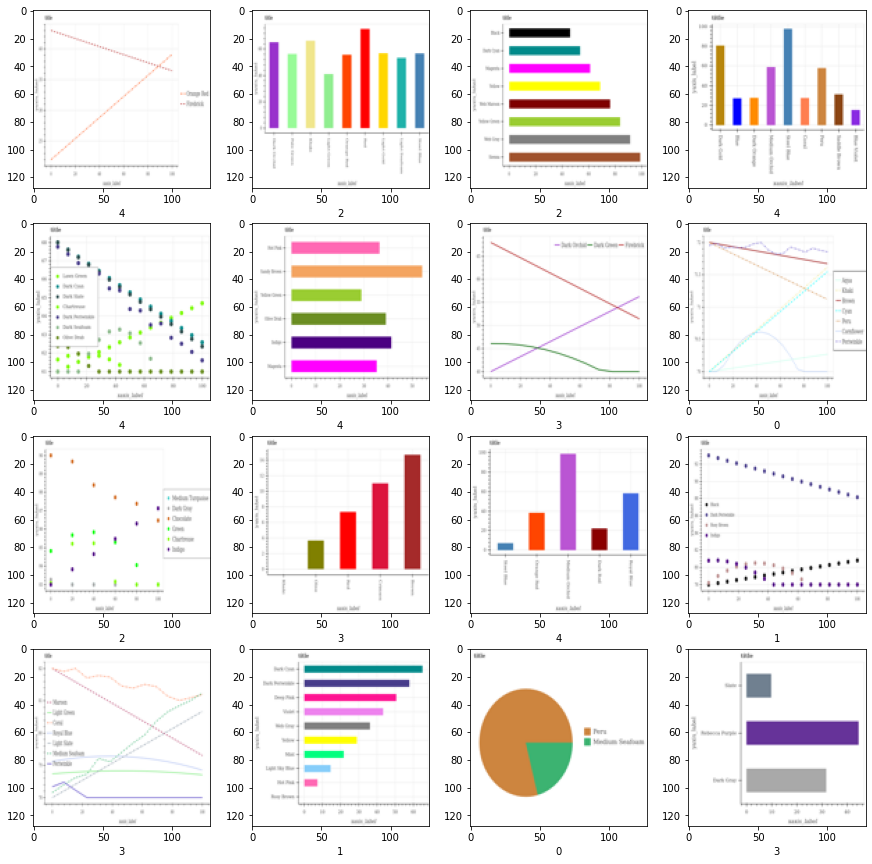

In [ ]:
img_path = np.random.choice(df['image_index'], 16)

fig, ax = plt.subplots(4,4,figsize=(15, 15))

for i in range(16):
    ax[int(i/4),int(i%4)].imshow(Image.open(f"/content/charts/train_val/{img_path[i]}.png"))
    ax[int(i/4),int(i%4)].set_xlabel(df['type'][img_path[i]])
plt.show()

In [ ]:
def train_test_split(dataset,split_ratio):
    train_len = int(len(dataset) * split_ratio)
    train = dataset[: train_len ]
    test = dataset[train_len: ]
    return train.reset_index(drop=True), test.reset_index(drop=True)


In [ ]:
train_data, test_data = train_test_split(df, 0.8)

In [ ]:
import tensorflow as tf

In [ ]:
train_images = []
train_labels = []
for i in range(len(train_data)):
    image = cv2.imread(train_data['path'][i])
    image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    image = image.astype('float32')
    image = image/255.
    train_images.append(image)
    train_labels.append(train_data['type'][i])

In [ ]:
train_images = np.array(train_images)
train_images = np.expand_dims(train_images,-1)
train_labels = np.array(train_labels)
train_labels = np.expand_dims(train_labels, -1)

In [ ]:
test_images = []
test_labels = []
for i in range(len(test_data)):
   
    image = cv2.imread(test_data['path'][i])
    image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    image = image.astype('float32')
    image = image/255.
    test_images.append(image)
    test_labels.append(test_data['type'][i])

In [ ]:
test_images = np.array(test_images)
test_images = np.expand_dims(test_images,-1)
test_labels = np.array(test_labels)
test_labels = np.expand_dims(test_labels,-1)

In [ ]:
model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(128, 128, 1)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Flatten())
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(5, activation = 'softmax'))

In [ ]:
model.summary()

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_18 (Conv2D)          (None, 126, 126, 32)      320       
                                                                 
 max_pooling2d_18 (MaxPoolin  (None, 63, 63, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_19 (Conv2D)          (None, 61, 61, 64)        18496     
                                                                 
 max_pooling2d_19 (MaxPoolin  (None, 30, 30, 64)       0         
 g2D)                                                            
                                                                 
 flatten_9 (Flatten)         (None, 57600)             0         
                                                                 
 dense_18 (Dense)            (None, 64)               

In [ ]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])

In [ ]:
history = model.fit(train_images, train_labels, epochs=10, validation_data =[test_images, test_labels])

Epoch 1/10
25/25 [==============================] - 18s 698ms/step - loss: 1.4983 - accuracy: 0.4275 - val_loss: 0.9781 - val_accuracy: 0.7050
Epoch 2/10
25/25 [==============================] - 16s 644ms/step - loss: 0.5301 - accuracy: 0.8188 - val_loss: 0.2990 - val_accuracy: 0.8550
Epoch 3/10
25/25 [==============================] - 16s 631ms/step - loss: 0.2418 - accuracy: 0.8975 - val_loss: 0.2318 - val_accuracy: 0.8950
Epoch 4/10
25/25 [==============================] - 17s 686ms/step - loss: 0.1290 - accuracy: 0.9488 - val_loss: 0.1715 - val_accuracy: 0.9350
Epoch 5/10
25/25 [==============================] - 16s 634ms/step - loss: 0.0746 - accuracy: 0.9775 - val_loss: 0.1513 - val_accuracy: 0.9400
Epoch 6/10
25/25 [==============================] - 16s 631ms/step - loss: 0.0345 - accuracy: 0.9900 - val_loss: 0.0850 - val_accuracy: 0.9700
Epoch 7/10
25/25 [==============================] - 16s 634ms/step - loss: 0.0226 - accuracy: 0.9962 - val_loss: 0.0760 - val_accuracy: 0.9650

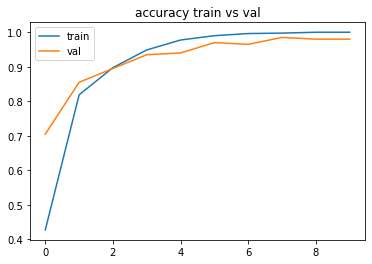

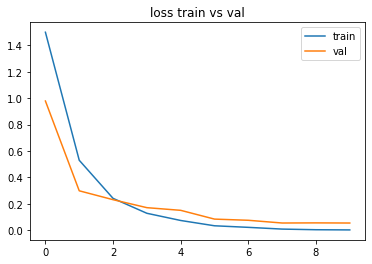

In [163]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title("accuracy train vs val")
labels = ['train', 'val']
plt.legend(labels)
plt.show()
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title("loss train vs val")
plt.legend(labels)
plt.show()

## Using a pretrained model

In [164]:
train_images_p = []
train_labels_p = []
for i in range(len(train_data)):
    image = cv2.imread(train_data['path'][i])
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = image.astype('float32')
    image = image/255.
    train_images_p.append(image)
    train_labels_p.append(train_data['type'][i])

In [165]:
train_images_p = np.array(train_images_p)

train_labels_p = np.array(train_labels_p)


In [168]:
test_images_p = []
test_labels_p = []
for i in range(len(test_data)):
    image = cv2.imread(test_data['path'][i])
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = image.astype('float32')
    image = image/255.
    test_images_p.append(image)
    test_labels_p.append(test_data['type'][i])

In [169]:
test_images_p = np.array(test_images_p)

test_labels_p = np.array(test_labels_p)


In [170]:
pretrained_model = tf.keras.applications.resnet50.ResNet50(
                        include_top=False,
                        weights='imagenet',
                        input_shape=(128,128,3))
pretrained_model.trainable = False
pretrained_model.summary()

94781440/94765736 [==============================] - 0s 0us/step
Model: "resnet50"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 134, 134, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 64, 64, 64)   9472        ['conv1_pad[0][0]']              
                                                                                                  
 conv1_bn (BatchNormalizat

In [171]:
image = cv2.imread('/content/charts/train_val/400.png')
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
image = image.astype('float32')
image = image/255.

In [174]:
inp = tf.keras.Input(shape=(128, 128, 3))
x = pretrained_model(inp, training=False)
x = tf.keras.layers.Flatten()(x)
x= layers.Dense(240, activation='relu')(x)
x= layers.Dense(64, activation='relu')(x)
outputs = layers.Dense(5, activation='softmax')(x)
model = tf.keras.Model(inp, outputs)

In [175]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])

In [176]:
history = model.fit(train_images_p, train_labels_p, epochs=10, 
                    validation_data=(test_images_p, test_labels_p))

Epoch 1/10
25/25 [==============================] - 57s 2s/step - loss: 1.0756 - accuracy: 0.5475 - val_loss: 0.6474 - val_accuracy: 0.7000
Epoch 2/10
25/25 [==============================] - 58s 2s/step - loss: 0.5126 - accuracy: 0.7925 - val_loss: 0.3738 - val_accuracy: 0.8750
Epoch 3/10
25/25 [==============================] - 53s 2s/step - loss: 0.3599 - accuracy: 0.8500 - val_loss: 0.2882 - val_accuracy: 0.9350
Epoch 4/10
25/25 [==============================] - 53s 2s/step - loss: 0.2902 - accuracy: 0.8725 - val_loss: 0.2349 - val_accuracy: 0.9450
Epoch 5/10
25/25 [==============================] - 54s 2s/step - loss: 0.2292 - accuracy: 0.9237 - val_loss: 0.2016 - val_accuracy: 0.9500
Epoch 6/10
25/25 [==============================] - 52s 2s/step - loss: 0.1980 - accuracy: 0.9362 - val_loss: 0.1974 - val_accuracy: 0.9650
Epoch 7/10
25/25 [==============================] - 54s 2s/step - loss: 0.1979 - accuracy: 0.9237 - val_loss: 0.1896 - val_accuracy: 0.9150
Epoch 8/10
25/25 [==

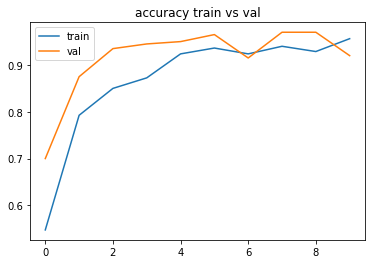

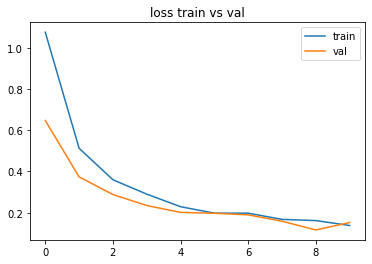

In [177]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title("accuracy train vs val")
labels = ['train', 'val']
plt.legend(labels)
plt.show()
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title("loss train vs val")
plt.legend(labels)
plt.show()

## GradCam

In [ ]:
train_images_g = []
train_labels_g = []
for i in range(len(train_data)):
    image = cv2.imread(train_data['path'][i])
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = cv2.resize(image, (224,224))
    image = image.astype('float32')
    image = image/255.
    train_images_g.append(image)
    train_labels_g.append(train_data['type'][i])

In [ ]:
train_images_g = np.array(train_images_g)
train_labels_g = np.array(train_labels_g)


In [ ]:
test_images_g = []
test_labels_g = []
for i in range(len(test_data)):
    image = cv2.imread(test_data['path'][i+800])
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = cv2.resize(image, (224,224))
    image = image.astype('float32')
    image = image/255.
    test_images_g.append(image)
    test_labels_g.append(test_data['type'][i+800])

In [ ]:
test_images_g = np.array(test_images_g)

test_labels_g = np.array(test_labels_g)


In [ ]:
def get_img_array(img_path, size):
    # `img` is a PIL image of size 299x299
    img = keras.preprocessing.image.load_img(img_path, target_size=size)
    # `array` is a float32 Numpy array of shape (299, 299, 3)
    array = keras.preprocessing.image.img_to_array(img)
    # We add a dimension to transform our array into a "batch"
    # of size (1, 299, 299, 3)
    array = np.expand_dims(array, axis=0)
    return array


def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    # First, we create a model that maps the input image to the activations
    # of the last conv layer as well as the output predictions
    grad_model = tf.keras.models.Model(
        [model.inputs], [model.get_layer(last_conv_layer_name).output, model.output]
    )

    # Then, we compute the gradient of the top predicted class for our input image
    # with respect to the activations of the last conv layer
    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]

    # This is the gradient of the output neuron (top predicted or chosen)
    # with regard to the output feature map of the last conv layer
    grads = tape.gradient(class_channel, last_conv_layer_output)

    # This is a vector where each entry is the mean intensity of the gradient
    # over a specific feature map channel
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    # We multiply each channel in the feature map array
    # by "how important this channel is" with regard to the top predicted class
    # then sum all the channels to obtain the heatmap class activation
    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    # For visualization purpose, we will also normalize the heatmap between 0 & 1
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()

In [ ]:
decode_predictions = tf.keras.applications.resnet50.decode_predictions

In [ ]:
pretrained_model_g = tf.keras.applications.resnet50.ResNet50(
                        include_top=True,
                        weights='imagenet',
                        input_shape=(224,224,3))
pretrained_model_g.trainable = True
pretrained_model_g.summary()

Model: "resnet50"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_15 (InputLayer)          [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_15[0][0]']               
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                           

[[-3.0812085e-01  3.7954119e-01 -1.2591155e+00 -6.7105639e-01
  -1.4455969e+00  7.5299430e-01 -3.1759706e+00 -1.6793289e+00
  -2.5568428e+00 -3.2217905e-01  1.2722715e+00 -3.1589177e-01
  -1.2181664e+00 -8.8228279e-01 -2.5655935e+00 -1.4690365e+00
  -4.8332360e-01 -1.9601518e+00 -1.2487240e+00 -1.3539457e+00
  -7.6322347e-02  2.1545792e+00  1.4714698e+00  6.5240689e-02
  -8.2780695e-01 -6.1871350e-01  4.4311273e-01  1.5399179e-01
  -2.1781212e-01 -8.4183633e-02 -1.5731578e+00  4.6320117e-01
  -8.9903760e-01 -5.6499946e-01  3.1242666e-01 -2.6467261e+00
  -4.5577091e-01 -2.9859881e+00  3.3157415e+00 -1.7492809e+00
  -1.4296138e+00 -9.8304331e-02  2.6519173e-01 -1.9081739e-01
  -1.2599903e+00 -4.7126245e-01 -1.6076607e+00  1.8029885e-01
  -1.7075304e+00 -1.6151237e+00 -1.6608411e-01  6.6528922e-01
   2.8131378e-01  8.8776153e-01  3.3768815e-01 -2.0938652e+00
  -1.1694853e+00 -2.6410713e+00 -3.9026818e-01  2.7436275e+00
   8.5295808e-01 -1.6226285e+00  4.4045964e-01  6.6352719e-01
   1.227

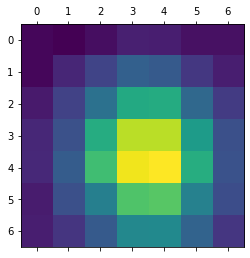

In [ ]:
# Remove last layer's softmax
pretrained_model_g.layers[-1].activation = None

# Print what the top predicted class is
preds = pretrained_model_g.predict(im)
print(preds)
print("Predicted:", decode_predictions(preds, top=1)[0])

# Generate class activation heatmap
heatmap = make_gradcam_heatmap(im, pretrained_model_g, 'conv5_block3_out')

# Display heatmap
plt.matshow(heatmap)
plt.show()

In [ ]:
import matplotlib.cm as cm
from IPython.display import Image, display

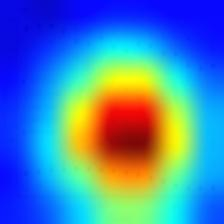

In [ ]:
def save_and_display_gradcam(img, heatmap, cam_path="cam.jpg", alpha=0.1):
    # Load the original image
    #img = keras.preprocessing.image.load_img(img_path)
    img = keras.preprocessing.image.img_to_array(img)

    # Rescale heatmap to a range 0-255
    heatmap = np.uint8(255 * heatmap)

    # Use jet colormap to colorize heatmap
    jet = cm.get_cmap("jet")

    # Use RGB values of the colormap
    jet_colors = jet(np.arange(256))[:, :3]
    jet_heatmap = jet_colors[heatmap]

    # Create an image with RGB colorized heatmap
    jet_heatmap = keras.preprocessing.image.array_to_img(jet_heatmap)
    jet_heatmap = jet_heatmap.resize((img.shape[1], img.shape[0]))
    jet_heatmap = keras.preprocessing.image.img_to_array(jet_heatmap)

    # Superimpose the heatmap on original image
    superimposed_img = jet_heatmap * alpha + img
    superimposed_img = keras.preprocessing.image.array_to_img(superimposed_img)

    # Save the superimposed image
    superimposed_img.save(cam_path)

    # Display Grad CAM
    display(Image(cam_path))


save_and_display_gradcam(image, heatmap)

In [ ]:
im = np.expand_dims(image, 0)

In [ ]:
cv2.imwrite('output.png', image)

True

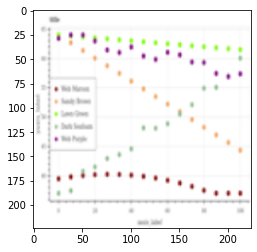

In [ ]:
plt.imshow(image)

In [ ]:
image.shape

(224, 224, 3)

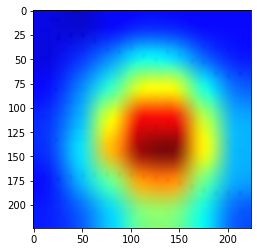

In [ ]:
heatmap = np.uint8(255 * heatmap)
jet = cm.get_cmap("jet")
jet_colors = jet(np.arange(256))[:, :3]
jet_heatmap = jet_colors[heatmap]

jet_heatmap = keras.preprocessing.image.array_to_img(jet_heatmap)
jet_heatmap = jet_heatmap.resize((image.shape[1], image.shape[0]))

jet_heatmap = keras.preprocessing.image.img_to_array(jet_heatmap)

# Superimpose the heatmap on original image
superimposed_img = jet_heatmap * 0.1 + image
superimposed_img = keras.preprocessing.image.array_to_img(superimposed_img)

# Save the superimposed image
# superimposed_img.save(cam_path)

# Display Grad CAM
# display(Image(cam_path))
plt.imshow(superimposed_img)

## prevention from adversarial attacks


In [ ]:
import numpy
import scipy.signal
import scipy.ndimage

def vifp_mscale(ref, dist):
    sigma_nsq=2
    eps = 1e-10

    num = 0.0
    den = 0.0
    for scale in range(1, 5):
       
        N = 2**(4-scale+1) + 1
        sd = N/5.0

        if (scale > 1):
            ref = scipy.ndimage.gaussian_filter(ref, sd)
            dist = scipy.ndimage.gaussian_filter(dist, sd)
            ref = ref[::2, ::2]
            dist = dist[::2, ::2]
                
        mu1 = scipy.ndimage.gaussian_filter(ref, sd)
        mu2 = scipy.ndimage.gaussian_filter(dist, sd)
        mu1_sq = mu1 * mu1
        mu2_sq = mu2 * mu2
        mu1_mu2 = mu1 * mu2
        sigma1_sq = scipy.ndimage.gaussian_filter(ref * ref, sd) - mu1_sq
        sigma2_sq = scipy.ndimage.gaussian_filter(dist * dist, sd) - mu2_sq
        sigma12 = scipy.ndimage.gaussian_filter(ref * dist, sd) - mu1_mu2
        
        sigma1_sq[sigma1_sq<0] = 0
        sigma2_sq[sigma2_sq<0] = 0
        
        g = sigma12 / (sigma1_sq + eps)
        sv_sq = sigma2_sq - g * sigma12
        
        g[sigma1_sq<eps] = 0
        sv_sq[sigma1_sq<eps] = sigma2_sq[sigma1_sq<eps]
        sigma1_sq[sigma1_sq<eps] = 0
        
        g[sigma2_sq<eps] = 0
        sv_sq[sigma2_sq<eps] = 0
        
        sv_sq[g<0] = sigma2_sq[g<0]
        g[g<0] = 0
        sv_sq[sv_sq<=eps] = eps
        
        num += numpy.sum(numpy.log10(1 + g * g * sigma1_sq / (sv_sq + sigma_nsq)))
        den += numpy.sum(numpy.log10(1 + sigma1_sq / sigma_nsq))
        
    vifp = num/den

    if numpy.isnan(vifp):
        return 1.0
    else:
        return vifp
    